#Titanic Survival Analysis
##Andrew Gill

I am in interested in what factors contributed to survival on the Titanic and if i can reliably predict if a passenger will survive? (> 80% success rate).

To do this I will examine the data using different plots as well as summary statistics, especially the mean, for different subgroups. I will then run different machine learning algorithms to to try and achieve a good prediction rate. 

In [1]:
import IPython.core.display as di
#code for this button is taken from a website
#source is included in sources textfile
# This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
import pandas as pd
import numpy as np
import pprint

titanic_df = pd.read_csv('titanic_data.csv')

###General Structure of Data

In [3]:
pprint.pprint(titanic_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


###Type of Data Contained in Dataframe

In [4]:
for col in titanic_df:
   print col, titanic_df[col].dtypes

PassengerId int64
Survived int64
Pclass int64
Name object
Sex object
Age float64
SibSp int64
Parch int64
Ticket object
Fare float64
Cabin object
Embarked object


In [5]:
#helper functions to transform data later on.
def convert_survivor(survived):
    if survived == 1:
        return "YES"
    else:
        return "NO"

In [6]:
#create copy of df to work with, if I just set the new df = to titanic_df 
#it will create a deep_copy and values
#changed in one will affect the values changed in another. 
clean_titanic_df = titanic_df.copy() 

In [7]:
#Will use the Alive column in graphs
#so it is easier to interpret than 1 and 0 for Survived
clean_titanic_df['Alive'] = clean_titanic_df['Survived'].apply(convert_survivor)
# check modification
#pprint.pprint(clean_titanic_df.head())

###Descriptive Statistics about the Survival Rate

In [8]:
clean_titanic_df['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

The General Survival rate is only 38.38%. Chances of survival overall are not very good. Different subgroups within the population probably have very different survival rates, such as women and children having better chances. I will explore different demographic groups later.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Feature Exploration

The variables I would expect to be most important are Sex, Age, and socioeconomic class. Will examine the general distribution of these features next. I will look at the distribution of sexes first. 

###Distribution of Sex

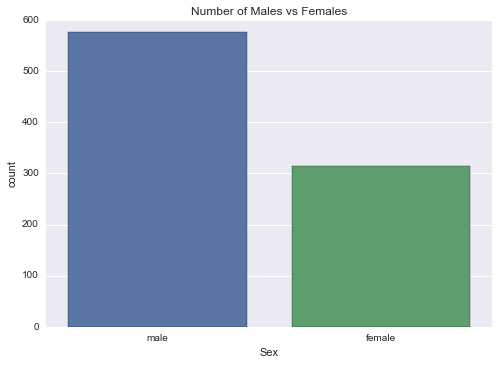

In [10]:
sns.countplot(titanic_df['Sex'])
plt.title("Number of Males vs Females")

There are almost twice as many males as females on board.

###Age Distribution

I examined ages in two different ways. One graph is a histogram, while in the other I grouped ages into groups based a Pew Research Center article. 

In [11]:
#print clean_titanic_df['Age'].head(10)
#create another dataframe so that age can be analyzed by dropping Nan values 
#without affecting other columns
clean_titanic_2 = clean_titanic_df.copy()[np.isfinite(clean_titanic_df["Age"])]
#line below is used to convert nan values in Age to the no_age group.
clean_titanic_df['Age'] = clean_titanic_df['Age'].fillna(0)
#clean_titanic_df['Age'].head(10)
age_bins = [0,0.001,13,18,50,66,100]
age_cat = ["No_Age","0-12","13-17","18-49","50-64","65+"]
clean_titanic_df['Age_Group'] = pd.cut(clean_titanic_df['Age'], 
                                       bins =age_bins,right=False, labels=age_cat )


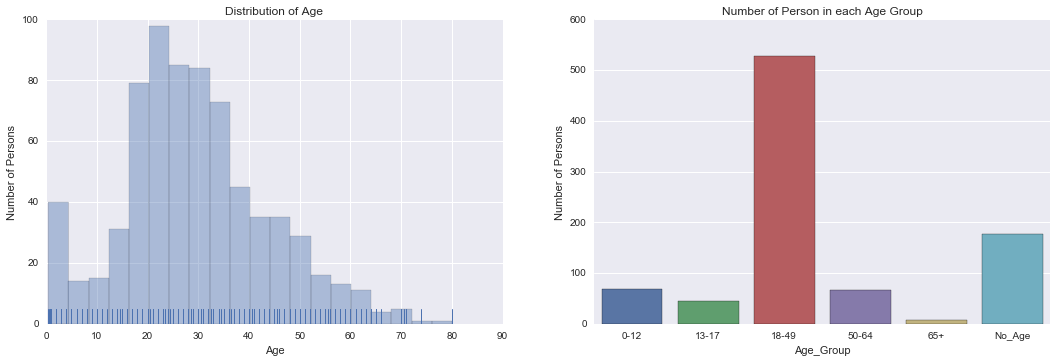

In [12]:


fig = plt.figure(figsize=(18,12))
fig.add_subplot(221)
a1 = sns.distplot(clean_titanic_2['Age'], kde = False, rug=True)
plt.ylabel("Number of Persons")
plt.title("Distribution of Age")

fig.add_subplot(222)
a2 = sns.countplot(x = clean_titanic_df['Age_Group'], order= ["0-12", "13-17", "18-49", "50-64", "65+", 'No_Age'])
plt.ylabel("Number of Persons")
plt.title("Number of Person in each Age Group")


The Age Group graph is more informative of the overall age distribution. Most passengers are in the 18-49 age group. Another significant amount are in the No_age group possibly because the passengers died and their age was unknown.

I am interested in seeing how the distribution of age differs by sex.

###Age Distribution by Sex

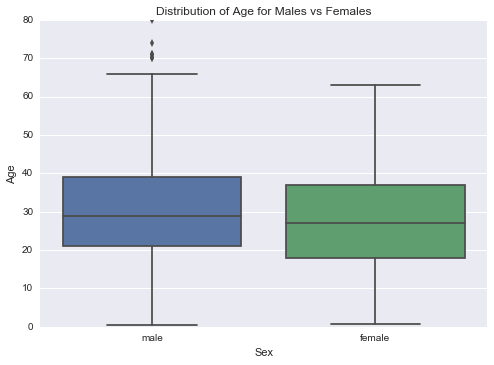

In [13]:
sns.boxplot(y="Age", x="Sex", data=clean_titanic_2)
plt.title("Distribution of Age for Males vs Females")

The distribution of age for men and women is largely the same. The median age for men is slightly higher and there are also some male outliers above the age of 70. 

###Fare Distribution

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

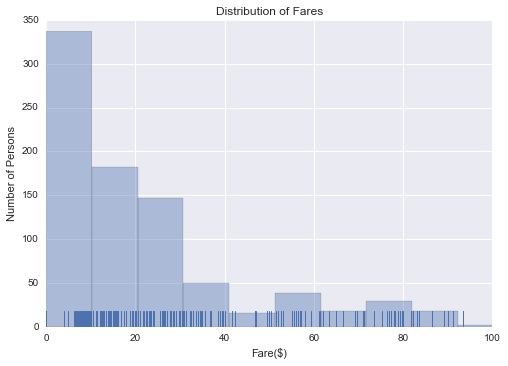

In [14]:
#Fare graph with limits on the x-axis. There are some very high outliers not shown that skew the graph. Upwards of 500 for Fare..
f1 = sns.distplot(clean_titanic_df['Fare'], kde = False, rug=True)
f1.set(xlim=(0, 100))
plt.ylabel("Number of Persons")
plt.xlabel("Fare($)")
plt.title("Distribution of Fares")

clean_titanic_df['Fare'].describe()

I think it may be better to think about the number of persons in each socioeconomic class instead of the fares they paid. 

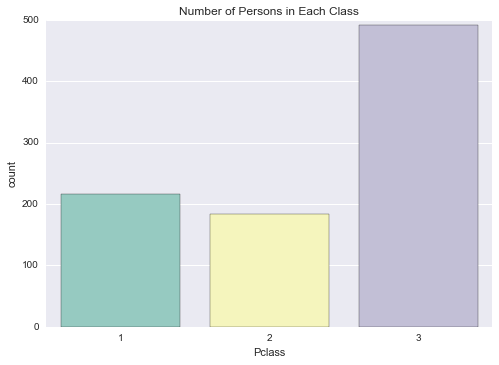

In [15]:
sns.countplot(x = clean_titanic_df['Pclass'], palette = "Set3")
plt.title("Number of Persons in Each Class")

The Pclass or socioeconomics class gives a much cleaner representation of a passenger's wealth and is most likely highly correlated with Fare price. The majority of passengers are third class. 

Interested in how class differers based on port of embarkation. 

###Number of Persons in Each Class by Port of Embarkation

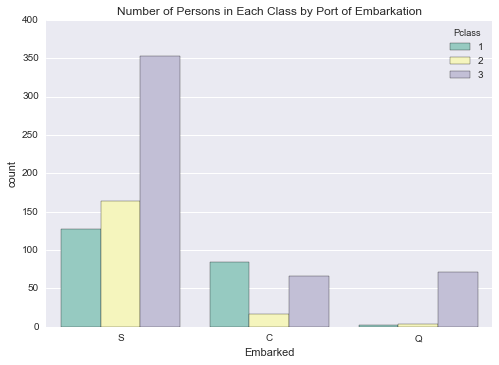

In [16]:
#Port(C = Cherbourg; Q = Queenstown; S = Southampton)
sns.countplot(x = clean_titanic_df['Embarked'], hue=clean_titanic_df["Pclass"], palette = "Set3")
plt.title("Number of Persons in Each Class by Port of Embarkation")

Most passengers embarked from Southampton. Also of note is that almost all passengers from Queenstown are third class. Port of embarkation will most likely not be useful in prediction of survival rates.

#Feature Exploration with Respect to Survival

###Survival Rate vs Sex

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


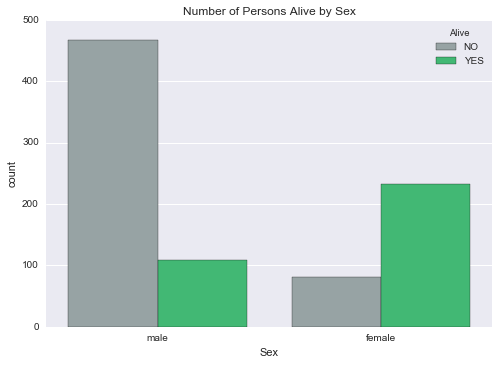

In [17]:
bySex = titanic_df.groupby('Sex')
print bySex['Survived'].mean()
sns.countplot(titanic_df['Sex'], hue = clean_titanic_df['Alive'], palette = ["#95a5a6", "#2ecc71"])
plt.title("Number of Persons Alive by Sex")

Striking difference between female and male survival rates. 74% (Female) vs 18.8% (Male)

###Survival Rate by Age Group

Age_Group
No_Age    0.293785
0-12      0.579710
13-17     0.477273
18-49     0.383302
50-64     0.393939
65+       0.125000
Name: Survived, dtype: float64


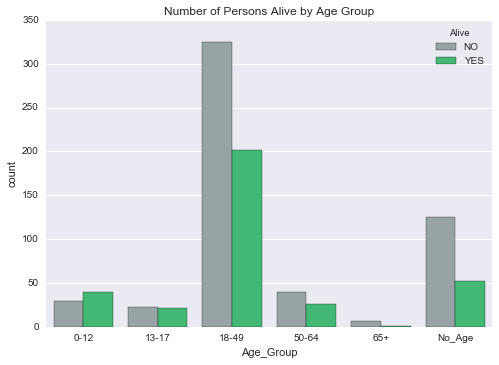

In [18]:
byAge_Group = clean_titanic_df.groupby('Age_Group')
print byAge_Group['Survived'].mean()
a2 = sns.countplot(x = clean_titanic_df['Age_Group'], 
                   order= ["0-12", "13-17", "18-49", "50-64", "65+", 'No_Age'],
                   hue=clean_titanic_df['Alive'],
                   palette = ["#95a5a6", "#2ecc71"])
plt.title("Number of Persons Alive by Age Group")

Children 0-12 and 13-17 also have a much higher survival rate then the rest of teh population. Those that are very elderly (65+) may not have been able to survive the elements thus explaining their low survival rates. Those with no age also have a below average survival rate. This may point towards the suspicion that many have no age listed because they died during the Titanic disaster.

###Survival Rate by Class

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


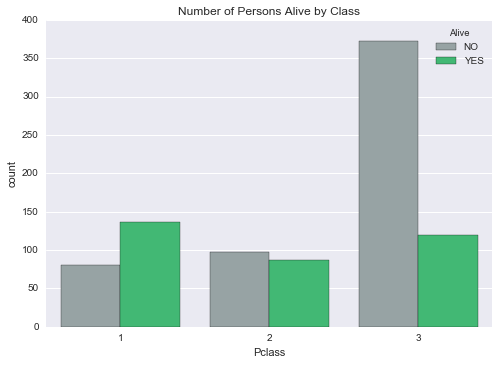

In [19]:
byPclass = titanic_df.groupby('Pclass')
print byPclass['Survived'].mean()
c1 = sns.countplot(x = clean_titanic_df['Pclass'], 
                   hue=clean_titanic_df["Alive"],
                   palette = ["#95a5a6", "#2ecc71"])
plt.title("Number of Persons Alive by Class")

Those in third class have by far the worst survival rate. While 1st class passengers faired even better than 2nd class.
Suggesting that socio-economic status matters alot for survival. 

#Exploring Survival Rates with Multiple Features

###Survival Rate by Class and Sex

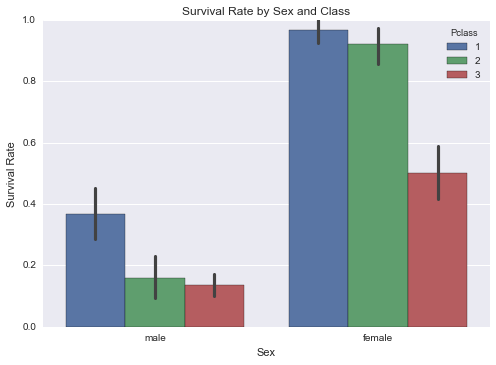

In [20]:
sns.barplot(x="Sex", y="Survived", hue = "Pclass", data= clean_titanic_df)
plt.title("Survival Rate by Sex and Class")
plt.ylabel("Survival Rate")

Women of the first and second class have an extremely high survival rate. Whereas women with a third class ticket have a survival rate that is significantly lower. Even though women with a third class ticket have a survival rate that is higher than men in first class, their 95% confidence intervals overlap. It is therefore possible that men in first class potentially have a true survival rate that is higher than women in third class. 

###Survival Rate by Class and Age Category
I used child to denote someone less than 13. I think this may be a more appropiate way to classify differences of age rather than looking at age as a continous variable or with more age categories as I had analyzed before. 

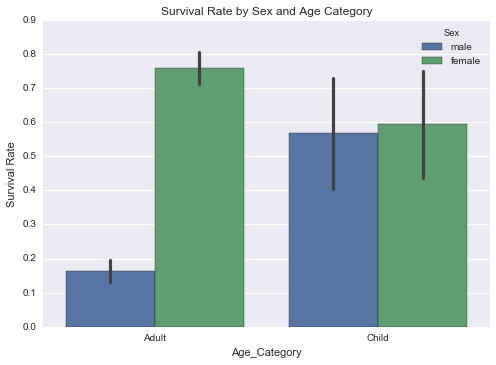

In [21]:
clean_titanic_df["Age_Category"] = clean_titanic_df["Age"].apply(lambda x: "Child" if (x > 0 and x < 13) else "Adult")
sns.barplot(x="Age_Category", y="Survived", hue = "Sex", data= clean_titanic_df)
plt.title("Survival Rate by Sex and Age Category")
plt.ylabel("Survival Rate")

Boys have a much higher survival rate then men. Although girls have a lower survival rate then women, both sexes of children have a large 95% confidence interval due to their small sample sizes. It is therefore possible that girls' survival rate is much closer to women's. 

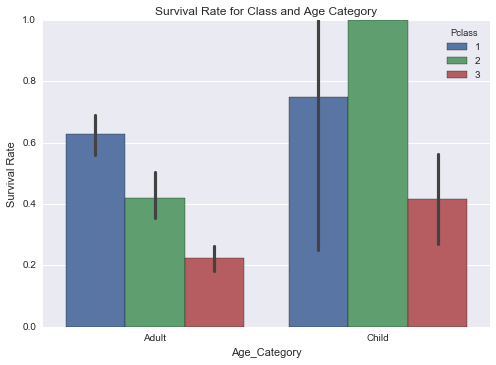

In [22]:
sns.barplot(x="Age_Category", y="Survived", hue = "Pclass", data= clean_titanic_df)
plt.title("Survival Rate for Class and Age Category")
plt.ylabel("Survival Rate")

All children with second class tickets survived. Overall, children are better off than adults controlling for class, but adults in first class have a higher survival rate than children in third. The confidence intervals for children are again very large due to small sample sizes. 

#Summary of Analysis so Far

It appears that Sex, Age, and SES do indeed matter for survival. However we can not make any definitive conclusions as to their correlation with Survival because statistical tests have not been run. Next I will run various machine learning classifiers with different feature combinations to see if I can predict passenger survival rates with >80% success rate.

#Predicting Survival of Passengers

In [34]:
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier

In [24]:
#functions to be used during machine learning classification
def fit_predict(classifier, features, n="all"):
    #input: ML classifier and dataframe containing relevant features
    #output - prints accuracy score of classifier and returns the pipeline object.
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size =.2, random_state = 40)
    pipe = Pipeline([("selector", SelectKBest(k=n)),
                     ("clf", classifier)])
    pipe.fit(features_train, labels_train)
    pred = pipe.predict(features_test)
    acc = accuracy_score(labels_test, pred)
    print "Accuracy Score:" ,acc
    return pipe

def plot_f_score(features):
    #plots feature scores for decision tree classifier
    feats = features.columns
    feature_scores = []
    scores = pipe.named_steps['selector'].scores_
    for i, x in enumerate(feats):
        feature_scores.append((feats[i], scores[i]))
    feature_scores = sorted(feature_scores, key=lambda feat_score: feat_score[1], reverse = True)
    feature_scores = pd.DataFrame(feature_scores, columns=["Features", "Scores"])
    feat_score_plot = sns.barplot(x=feature_scores["Features"], y=feature_scores["Scores"], color='b')
    plt.setp(feat_score_plot.get_xticklabels(), rotation=90)
    plt.ylabel("F-Score")
    plt.title("F-Score for Each Feature")
    plt.tight_layout()
    plt.show()
    
def get_importances(features):
    #gets the importances for a decision tree classifier when using a pipeline
    importances = pipe.named_steps['clf'].feature_importances_
    for i, imp in enumerate(importances):
           print (i, features.columns[i], imp)

###Feature Creation and Extraction
I dropped the cabin number since there were so many missing values for that feature. I also dropped features that did not make any sense for classification, such as name. 
I also created dummy variables for the port of embarkation as well as reusing the child feature I created earlier. 

In [25]:
labels = clean_titanic_df["Survived"] 
features = clean_titanic_df.loc[:,('Pclass', "Age","Sex", 'SibSp', 'Parch', 'Fare',)]
#pprint.pprint(titanic.head(10))
features["Age"].replace(to_replace=0.0, value=features["Age"].median(), inplace=True)
features["Sex"] = LabelEncoder().fit_transform(features['Sex'])
#age probably isnt as important as if someone was a child or not. 
features["Child"] = features["Age"].apply(lambda x: 1 if x < 13 else 0)
#female: 0,  male: 1
#This takes care of of two NaN values for embarked as 0 will be used for all 3 dummy values
dummy = pd.get_dummies(clean_titanic_df['Embarked'], prefix="Embarked" )
features = features.join(dummy)
#pprint.pprint(features.head(10))

##Feature Selection with Decision Tree Classifier
I initially ran the classifier with all relevant features to understand which features contributed the most to classification. 

In [26]:
pipe = fit_predict(DecisionTreeClassifier(random_state=61), features)

Accuracy Score: 0.798882681564


The initial accuracy is .799, which is rather good. 

I will use the F-Score of each feature as well as the feature importances from the decision tree to decide which features to remove.

###F-Score for Each Feature

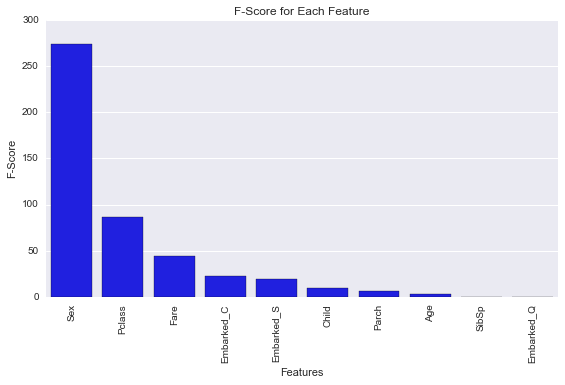

In [27]:
plot_f_score(features)

Sex, Pclass, and Fare have the highest F-Scores. The F-Score is helpful so I know how important features are independent of one another, but I will mainly be using the feature importances for feature selection. 

###Feature Importances

In [28]:
get_importances(features)

(0, 'Pclass', 0.10966780160755987)
(1, 'Age', 0.22046409074233672)
(2, 'Sex', 0.29223072854445914)
(3, 'SibSp', 0.080145474143123285)
(4, 'Parch', 0.038296389646793119)
(5, 'Fare', 0.24787634561252023)
(6, 'Child', 0.0)
(7, 'Embarked_C', 0.0024645221160821654)
(8, 'Embarked_Q', 0.0066571497717165988)
(9, 'Embarked_S', 0.002197497815408836)


I will run the classifier again with Sex, Pclass, Fare, Age, and SibSp due to those having the highest feature importances. Surprisingly child has a  feature importance of 0 due to that information being captured by the age feature. 

In [29]:
feat_main = features.loc[:,("Sex", "Pclass", "Fare", "Age", "SibSp")]
pipe = fit_predict(DecisionTreeClassifier(random_state=61), feat_main)
print '-' * 50
get_importances(feat_main)

Accuracy Score: 0.837988826816
--------------------------------------------------
(0, 'Sex', 0.29341771873696065)
(1, 'Pclass', 0.1120125396330017)
(2, 'Fare', 0.26487638350440262)
(3, 'Age', 0.25620794771235339)
(4, 'SibSp', 0.073485410413281646)


Dropping the unimportant features has increased the accuracy by a few percentage points. 

Since Fare and Pclass convey much of the same information. I am interested if the performance will stay the same if I drop one of them. I will also experiment dropping SibSp since it has the lowest feature importance. (SibSp indicates the combined number of siblings and spouses on board.)

In [30]:
def remove_feats(drop_list, features_list): 
    for feat in drop_list: 
        temp_list = features_list[:]
        temp_list.remove(feat)
        feat_df = features.loc[:,temp_list]
        print "Dropping ", feat
        pipe = fit_predict(DecisionTreeClassifier(random_state=61), feat_df)
        print "-" * 25

In [31]:
drop_list = ["Pclass", "Fare", "SibSp"]
features_list = ["Sex", "Pclass", "Fare", "Age", "SibSp"]
remove_feats(drop_list, features_list)

Dropping  Pclass
Accuracy Score: 0.765363128492
-------------------------
Dropping  Fare
Accuracy Score: 0.782122905028
-------------------------
Dropping  SibSp
Accuracy Score: 0.815642458101
-------------------------


Dropping Pclass and Fare both hurt accuracy as would be expected since they both have decent feature importances, even though they convey similar information . Dropping SibSp also decreases performance so I will retain all of these features. 

#Selecting a Classifier
I would like to test some other classifiers to see if I can increase the performance further. Currently the best performance is an accuracy score of .838. 

###Naive Bayes

In [32]:
pipe = fit_predict(GaussianNB(), feat_main)

Accuracy Score: 0.815642458101


Close to the best score so far, but not as good. 

###AdaBoost Decision Tree

In [33]:
pipe = fit_predict(AdaBoostClassifier(), feat_main)

Accuracy Score: 0.854748603352


The AdaBoost decision tree has the best performance yet at .855. 

##Limitations

###Missing Observations

I had 891 observations in my dataset, but there were 2,228 people on board the Titanic, of which 1,343 were passengers. These missing observations would provide a better picture and should improve the performance of my algorithm. 

###Missing Features

Another limitation is where exactly the passengers were located on the Titanic at the time of incident. Third class ticket holders that were located where the ship hit the iceberg would most likely have the poorest chance of survival. If they happened to be on the upper deck at the time of the incident, I would except their chance of survival to increase.

###Missing Values

There were almost 200 passengers that had missing age values. This probably affects the perception of how age affects survival as I imputed the median age (28) for the missing values during the classification process. Many of these passengers may have been children, which would then impact the performance as their survival rates are generally better- holding all other features constant. 

#Summary of Machine Learning Findings

I was able to successfully achieve my initial goal of predicting a survival rate with greater than 80% accuracy. The AdaBoost decision tree had an accuracy of .855.  The final features I used were Sex, Pclass, Fare, Age, and SibSp.
For future analysis, if I tested more algorithms or performed parameter tuning on the AdaBoost decision tree, I may be able to get a slight increase in performance. 